Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [294]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head(20))

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
1949-06,135
1949-07,148
1949-08,148
1949-09,136


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [295]:
# Створення змінної типу numpy.ndarray з кількості пасажирів у форматі float32
passengers = df['Passengers'].values.astype(np.float32)

# Перевіримо результат
print(passengers[:5])
print(type(passengers), passengers.dtype)

[112. 118. 132. 129. 121.]
<class 'numpy.ndarray'> float32


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [296]:
# Кількість екземплярів у всьому наборі
n_samples = len(passengers)

# Тренувальні дані 67%
train_size = int(n_samples * 0.67)

# Розбиття даних
train = passengers[:train_size]
test = passengers[train_size:]

# Перевіримо розміри
print(f"Загальна кількість: {n_samples}")
print(f"Розмір тренувального набору: {len(train)}")
print(f"Розмір валідаційного набору: {len(test)}")


Загальна кількість: 144
Розмір тренувального набору: 96
Розмір валідаційного набору: 48


Ми поділили дані на два набори: тренувальний - 96 спостережень та валідаційний - 48 спостережень.

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [298]:
import torch

def create_dataset(data, lookback):
    X = []
    y = []
    for i in range(len(data) - lookback):
        X.append([data[i + j] for j in range(lookback)])
        y.append(data[i + lookback])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [300]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

Для тренування моделі у нас є 95 зразків (X_train), для тестування — 47 зразків (X_test).

Для кожного зразка є лише 1 ознака (вхід), що є кількістю пасажирів за попередній місяць.

Для кожного зразка є лише 1 цільове значення (кількість пасажирів в наступному місяці), яке ми хочемо передбачити.



**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [301]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()

        # LSTM-шар
        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Лінійний шар для перетворення виходу LSTM в прогноз
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Проходимо через LSTM
        lstm_out, _ = self.lstm(x)

        # Отримуємо прогноз через лінійний шар
        output = self.fc(lstm_out[:, -1, :])

        return output


In [304]:
# Створюємо модель
model = AirModel(hidden_size=50, num_layers=1)

# Тензор для тестування
input_tensor = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(-1)  # shape: (1, 1, 1)

# Отримуємо прогноз від моделі
output = model(input_tensor)

# Виводимо результат
print(output)

# Розмірність
print(output.shape)

tensor([[0.3116]], grad_fn=<AddmmBackward0>)
torch.Size([1, 1])


Модель з рандомними вагами дала прогноз, що дорівнює tensor([[0.3116]] для переданого tensor([[112.]]).

Розмірність torch.Size([1, 1]) - означає, що тензор має двовимірну структуру з 1 рядком і 1 стовпцем.

Значення, яке ми отримали не є точним прогнозом, оскільки ми не тренували модель, і ваги моделі випадково ініціалізовані.

Атрибут grad_fn означає, що PyTorch відслідковує, як цей результат був обчислений, щоб пізніше використовувати його для обчислення градієнтів під час тренування моделі (як частину процесу backpropagation).


Висновок: модель працює і може генерувати вихід на основі рандомних ваг, але для реального прогнозу потрібно провести тренування моделі на даних, щоб вона могла навчитись коректно передбачати результати.

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [305]:
from torch.utils.data import DataLoader, TensorDataset

# Модель LSTM очікує вхід з 3-ма розмірностями
X_train = X_train.unsqueeze(1)

# Створення TensorDataset для об'єднання X_train і y_train
train_dataset = TensorDataset(X_train, y_train)

# Створення DataLoader для завантаження даних
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Для тестових даних
X_test = X_test.unsqueeze(1)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Перевіримо, як виглядає перший батч
for batch_X, batch_y in train_loader:
    print(f"batch_X: {batch_X}")
    print(f"batch_y: {batch_y}")
    print(f"batch_X shape: {batch_X.shape}, batch_y shape: {batch_y.shape}")
    break


batch_X: tensor([[[194.]],

        [[149.]],

        [[104.]],

        [[236.]],

        [[150.]],

        [[135.]],

        [[233.]],

        [[306.]]])
batch_y: tensor([[196.],
        [170.],
        [118.],
        [235.],
        [178.],
        [148.],
        [267.],
        [271.]])
batch_X shape: torch.Size([8, 1, 1]), batch_y shape: torch.Size([8, 1])


Ми створили DataLoader, який завантажує дані в батчах розміром 8 екземплярів та має параметр shuffle=True, щоб дані перемішувалися.
Батч відповідає формату вводу для LSTM.


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [312]:
import torch.optim as optim

# Функція тренування та валідації моделі
def train_and_validate(model, train_loader, test_loader, epochs, learning_rate=0.001):

    # Визначення функції втрат та оптимізатора
    criterion = nn.MSELoss()  # МSE (середньоквадратична похибка)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []  # Список для зберігання втрат

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Тренування на всіх батчах
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()  # Обнуляємо градієнти

            # Прогноз
            output = model(batch_X)

            # Обчислення втрат
            loss = criterion(output, batch_y)

            # Зворотний прохід та оновлення ваг
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        losses.append(train_loss / len(train_loader))  # Додаємо середнє значення втрат

        # Валідація раз на 100 епох
        if (epoch + 1) % 100 == 0:
            model.eval()  # Установлюємо модель в режим валідації
            with torch.no_grad():  # Не обчислюємо градієнти для валідації
                train_rmse = 0.0
                test_rmse = 0.0

                # Обчислення RMSE для тренувальних даних
                for batch_X, batch_y in train_loader:
                    output = model(batch_X)
                    rmse = torch.sqrt(criterion(output, batch_y))
                    train_rmse += rmse.item()

                # Обчислення RMSE для тестових даних
                for batch_X, batch_y in test_loader:
                    output = model(batch_X)
                    rmse = torch.sqrt(criterion(output, batch_y))
                    test_rmse += rmse.item()

                # Середнє значення RMSE по всіх батчах
                train_rmse /= len(train_loader)
                test_rmse /= len(test_loader)

                # Виведення результатів
                print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

    return losses


In [313]:
model = AirModel(hidden_size=50, num_layers=1)
# Кількість епох
epochs = 2000

losses = train_and_validate(model, train_loader, test_loader, epochs)

Epoch 100: train RMSE 186.2917, test RMSE 380.3245
Epoch 200: train RMSE 153.6468, test RMSE 346.2813
Epoch 300: train RMSE 124.5319, test RMSE 314.8212
Epoch 400: train RMSE 101.0204, test RMSE 285.8741
Epoch 500: train RMSE 82.5632, test RMSE 259.7232
Epoch 600: train RMSE 64.4422, test RMSE 234.4634
Epoch 700: train RMSE 52.3660, test RMSE 210.8108
Epoch 800: train RMSE 44.1102, test RMSE 189.3663
Epoch 900: train RMSE 35.5609, test RMSE 170.0562
Epoch 1000: train RMSE 31.6246, test RMSE 153.0013
Epoch 1100: train RMSE 30.2836, test RMSE 139.2981
Epoch 1200: train RMSE 27.6457, test RMSE 127.8511
Epoch 1300: train RMSE 25.0131, test RMSE 118.4500
Epoch 1400: train RMSE 24.2693, test RMSE 110.3560
Epoch 1500: train RMSE 23.6428, test RMSE 104.5597
Epoch 1600: train RMSE 23.4159, test RMSE 99.9691
Epoch 1700: train RMSE 23.3448, test RMSE 97.2356
Epoch 1800: train RMSE 24.2427, test RMSE 93.3355
Epoch 1900: train RMSE 23.0588, test RMSE 92.4643
Epoch 2000: train RMSE 22.8906, test RMS

Модель стабільно зменшує помилку на тренувальній вибірці:

RMSE знизився з 186.29 (на 100-й епосі) до 22.89 (на 2000-й епосі).

Це означає, що модель добре адаптувалася до навчальних даних.

На тестовій вибірці RMSE також поступово зменшується, проте навіть після 2000 епох RMSE залишається високим — 90.40.

Це вказує на обмежену здатність до узагальнення: модель не здатна вловити повну структуру даних (особливо сезонність).

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

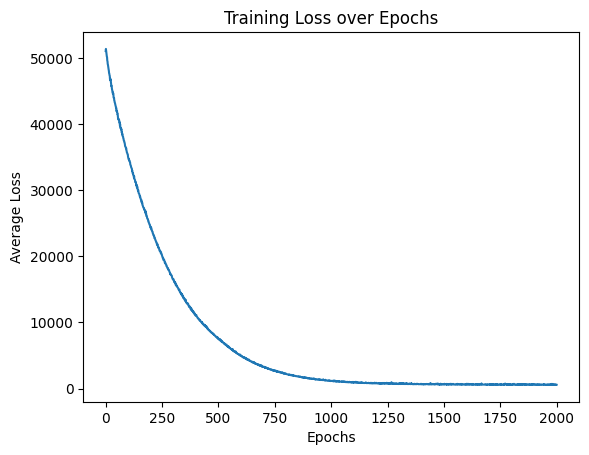

In [314]:
# Побудова графіка лосів
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.show()

Графік показує, що модель навчилась. Вона зменшила втрати до стабільно низького рівня, вийшла на плато.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

In [310]:
timeseries=passengers

<ipython-input-315-f885d675f3c1>:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
<ipython-input-315-f885d675f3c1>:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


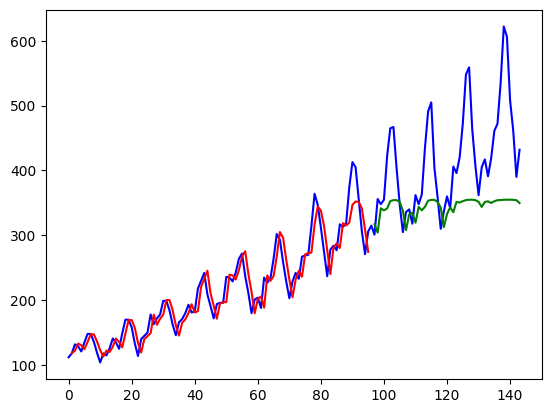

In [315]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

На нашому графіку червона лінія (тренувальні прогнози) непогано повторює синю (ground truth) на тренувальному відрізку.

Це узгоджується з низьким RMSE на train set у пізніх епохах (~23).

На тестовому відрізку зелена крива набагато гірше повторює синю — вона згладжує сезонні коливання.

Модель зберігає тренд (розуміє загальний напрямок зростання), але досить слабо.

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [316]:
model = AirModel(hidden_size=100, num_layers=1)

In [317]:
losses = train_and_validate(model, train_loader, test_loader, epochs)

Epoch 100: train RMSE 145.3113, test RMSE 335.6768
Epoch 200: train RMSE 94.4796, test RMSE 275.2856
Epoch 300: train RMSE 65.8725, test RMSE 229.8207
Epoch 400: train RMSE 45.3341, test RMSE 191.9199
Epoch 500: train RMSE 32.7203, test RMSE 161.3866
Epoch 600: train RMSE 27.0682, test RMSE 137.8889
Epoch 700: train RMSE 26.3360, test RMSE 119.4442
Epoch 800: train RMSE 24.3052, test RMSE 107.7274
Epoch 900: train RMSE 23.2725, test RMSE 99.1507
Epoch 1000: train RMSE 26.9578, test RMSE 100.6846
Epoch 1100: train RMSE 22.6743, test RMSE 88.9840
Epoch 1200: train RMSE 22.6406, test RMSE 87.1987
Epoch 1300: train RMSE 22.7087, test RMSE 86.7403
Epoch 1400: train RMSE 22.4186, test RMSE 82.2542
Epoch 1500: train RMSE 22.6195, test RMSE 81.9689
Epoch 1600: train RMSE 22.6737, test RMSE 82.9075
Epoch 1700: train RMSE 22.4601, test RMSE 81.0356
Epoch 1800: train RMSE 22.6675, test RMSE 78.7149
Epoch 1900: train RMSE 22.9340, test RMSE 80.3599
Epoch 2000: train RMSE 22.9055, test RMSE 78.0579

Модель з hidden_size=100 навчається швидше (менші RMSE вже на 500 епосі).

Дає кращі результати як на тренуванні, так і на тесті.

RMSE все ж на тестовому наборі значно вище ніж на тренувальному, можливо в нашої моделі недостатньо складна архітектура, num_layers=1 може бути мало для складної залежності (тренд + сезонність).


Модель не бачить достатньо інформації - коротке вікно не дає моделі можливості вловити сезонність.

Можливо через відсутність інформативних ознак, наприклад, таких як місяць, квартал, рік.